# RefuseCat Results
In contact.

## Loading in the data

In [14]:
from pathlib import Path


data_path = Path('/Users/dm236/Documents/Research/radarcat/trashcat/starcat_data_contact')

In [15]:
from typing import List

import numpy as np
from peewee import *

# open the database and create it if required
db = SqliteDatabase(data_path / 'store.db')


# set up the database models
class Sample(Model):
    label = CharField()
    filename = CharField()
    device = CharField()

    class Meta:
        database = db


# set up the tables if they do not exist
db.connect()
if 'sample' not in db.get_tables():
    db.create_table(Sample)
db.close()


def load_all_samples() -> List[Sample]:
    """
    Get all the samples in the database and return them.
    :return: List of samples ordered by id
    """
    db.connect()
    samples = [s for s in Sample.select().dicts()]
    db.close()

    for sample in samples:
        data = load_sample_data(sample)
        sample['data'] = data  # add data to the dictionary

    return samples


def load_sample_data(record: Sample) -> np.ndarray:
    """
    Load the data for a sample from it's file.
    :param sample: Sample record from the database.
    :return: Numpy array with the sample data in it
    """
    filepath = data_path / record['filename']
    data = np.loadtxt(filepath)
    return data


def samples_to_arrays(samples: List[Sample]):
    labels = np.array([sample['label'] for sample in samples])
    arrays = np.array([sample['data'] for sample in samples])
    return labels, arrays

In [16]:
# load in the samples and their labels
labels, data = samples_to_arrays(load_all_samples())
labels.shape, data.shape

((270,), (270, 768))

In [17]:
print(f"Unique Labels: {np.unique(labels)}")

Unique Labels: ['Air' 'Battery' 'Ceramic Mug' 'Confuser' 'Paper Ball' 'Paper Cup'
 'Small Box' 'Small Plastic Bag' 'phone']


# Preprocess
We went to have a numerical labels for each sample and split them into 70/30 train test.

In [18]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels)
list(label_encoder.classes_)

['Air',
 'Battery',
 'Ceramic Mug',
 'Confuser',
 'Paper Ball',
 'Paper Cup',
 'Small Box',
 'Small Plastic Bag',
 'phone']

In [19]:
targets = label_encoder.transform(labels)

In [20]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=0, stratify=targets)

# Training
Now we are ready to try out some classifiers.

In [21]:
from sklearn.preprocessing import StandardScaler

# normalise the data
scalar = StandardScaler()
scalar.fit(X_train)
X_train_std = scalar.transform(X_train)
X_test_std = scalar.transform(X_test)

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    'MLPC': MLPClassifier(solver='adam', activation='tanh',
                          early_stopping=False, max_iter=300,
                          alpha=0.01, hidden_layer_sizes=(128, 128, 128)),
    'RF': RandomForestClassifier(n_estimators=100),
    'SVC': SVC()
}

In [32]:
trained_models = {key: classifier.fit(X_train_std, y_train) for key, classifier in classifiers.items()}
#for key, model in trained_models.items():
#    model.classes_ = label_encoder.classes_

Note that the neural network failed to converge.

## Testing

In [33]:
y_preds_for_each_model = {key: model.predict(X_test_std) for key, model in trained_models.items()}

In [34]:
for key, y_preds in y_preds_for_each_model.items():
    print(key)
    print(np.unique(y_preds))
    print()

MLPC
[0 1 2 3 4 5 6 7 8]

RF
[0 1 2 3 4 5 6 7 8]

SVC
[0 1 2 3 5 6 7 8]



MLPC accuracy: 0.8395061728395061
RF accuracy: 0.8518518518518519
SVC accuracy: 0.691358024691358


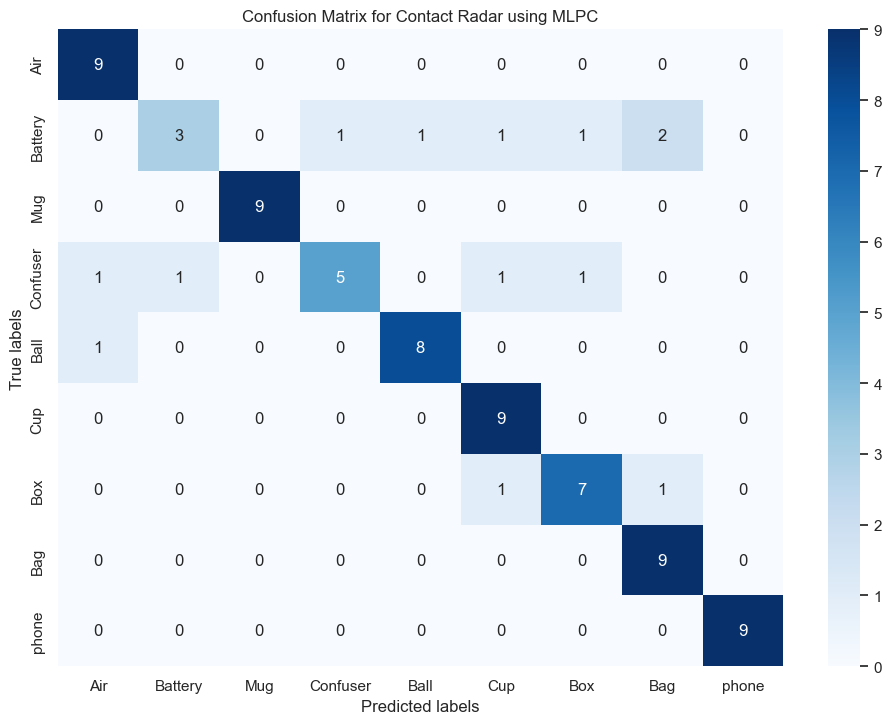

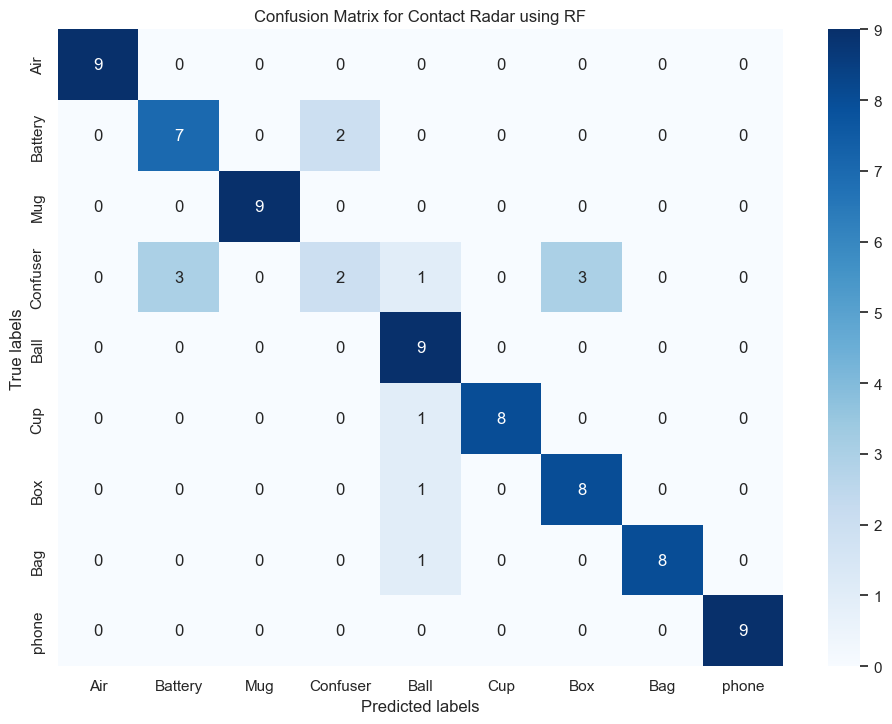

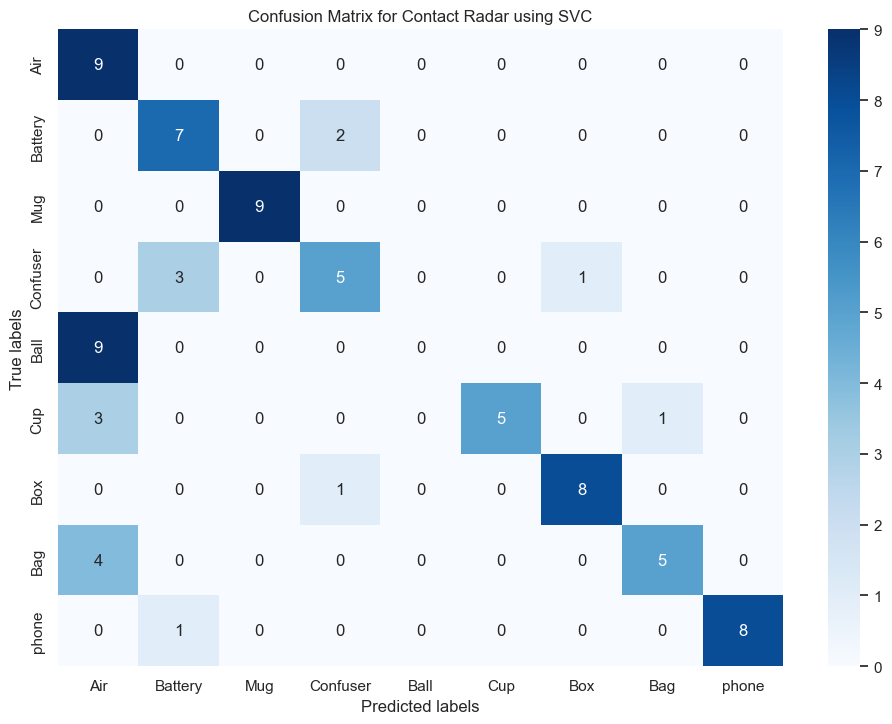

In [41]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

def cm(model_name, expected, predicted):
    cm = metrics.confusion_matrix(expected, predicted)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues');

    # labels, title and ticks
    ticks = [c.split()[-1] for c in label_encoder.classes_]
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(f'Confusion Matrix for Contact Radar using {model_name}') 
    ax.xaxis.set_ticklabels(ticks)
    ax.yaxis.set_ticklabels(ticks)
    plt.show()


for key, y_preds in y_preds_for_each_model.items():
    print(f'{key} accuracy:', metrics.accuracy_score(y_preds, y_test))

for key, y_preds in y_preds_for_each_model.items():
    cm(key, y_test, y_preds)